In [28]:
import os
import torch
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import torch.nn.functional as F
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import ViTForImageClassification, DefaultDataCollator, AdamW

In [42]:
batch_size = 32
dataset_code = 'A'
model_name = 'ViT'
data_saved_dir = r'E:\Post-Flood-Disaster-Management\Classification\pickle_data'
# model_saved_dir = r'D:\My Code\Classification\models'
model_saved_dir = r'E:\Post-Flood-Disaster-Management\Classification\models'
train_data_path = f'{data_saved_dir}\A_training.pkl'
val_data_path = f'{data_saved_dir}\A_validation.pkl'
test_data_path = f'{data_saved_dir}\A_testing.pkl'

In [22]:
def convert_to_rgb(images):
    if images.shape[1] == 1:  # Grayscale to RGB
        return np.repeat(images, 3, axis=1)
    elif images.shape[1] == 256:  # Reduce to 3 channels
        return images[:, :3, :, :]  # Select the first 3 channels
    else:
        raise ValueError(f"Unexpected number of channels: {images.shape[1]}")

In [24]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_images, train_labels = load_pickle(train_data_path)
val_images, val_labels = load_pickle(val_data_path)
test_images, test_labels = load_pickle(test_data_path)

# Convert (batch, height, width, channels) to (batch, channels, height, width)
train_images = np.transpose(train_images, (0, 3, 1, 2))
val_images = np.transpose(val_images, (0, 3, 1, 2))
test_images = np.transpose(test_images, (0, 3, 1, 2))

print(f'Training images: {train_images.shape}')
print(f'Validation images: {val_images.shape}')
print(f'Testing images: {test_images.shape}')

Training images: (3921, 3, 256, 256)
Validation images: (838, 3, 256, 256)
Testing images: (845, 3, 256, 256)


In [29]:
# Resize images to 224x224
def resize_images(images, target_size=(224, 224)):
    return F.interpolate(images, size=target_size, mode='bilinear', align_corners=False)

train_images = resize_images(train_images)
val_images = resize_images(val_images)
test_images = resize_images(test_images)

print(f'Training images: {train_images.shape}')
print(f'Validation images: {val_images.shape}')
print(f'Testing images: {test_images.shape}')

Training images: torch.Size([3921, 3, 224, 224])
Validation images: torch.Size([838, 3, 224, 224])
Testing images: torch.Size([845, 3, 224, 224])


In [30]:
# Convert numpy arrays to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_images = torch.tensor(val_images, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Example: Iterating through the DataLoader
for batch_images, batch_labels in train_loader:
    print(f'Batch images: {batch_images.shape}, Batch labels: {batch_labels.shape}')
    break  # Only show the first batch

C:\Users\Abdul Manaf\AppData\Local\Temp\ipykernel_19760\552756072.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_images = torch.tensor(train_images, dtype=torch.float32)
C:\Users\Abdul Manaf\AppData\Local\Temp\ipykernel_19760\552756072.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.long)
C:\Users\Abdul Manaf\AppData\Local\Temp\ipykernel_19760\552756072.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_images = torch.tensor(val_images, dtype=torch.float32)
C:\Users

Batch images: torch.Size([32, 3, 224, 224]), Batch labels: torch.Size([32])


In [35]:
# Prepare ViT model
from transformers import ViTForImageClassification, ViTFeatureExtractor

vit_model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)
model = ViTForImageClassification.from_pretrained(
    vit_model_name,
    num_labels=2,  # Binary classification: flood or not flood
    ignore_mismatched_sizes=True   # Binary classification: flood or not flood
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import time

# To store metrics
metrics = []

# Early stopping setup
best_val_loss = float('inf')
patience = 5
counter = 0  # Tracks the number of epochs without improvement

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Create a directory to save the model
model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
else:
    print(f'{model_dir} already exists')

# Training loop
model.train()
for epoch in range(100):  # Up to 100 epochs
    start_time = time.time()  # Start time for the epoch
    
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = train_correct / train_total

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # No gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            # Metrics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total

    # Epoch time
    epoch_time = time.time() - start_time

    # Store metrics
    metrics.append([epoch + 1, train_accuracy, train_loss, val_accuracy, val_loss, epoch_time])

    # Print metrics
    print(f"Epoch {epoch + 1}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
          f"Time: {epoch_time:.2f}s")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset patience counter
        print("Validation loss improved. Saving the model.")
        filepath = f'{model_saved_dir}\{dataset_code}_{model_name}_best_model.pth'
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        counter += 1
        print(f"Validation loss did not improve. Patience: {counter}/{patience}")

    if counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

# Display stored metrics
print("\nEpoch Metrics:")
for m in metrics:
    print(f"Epoch {m[0]}: Train Acc: {m[1]:.4f}, Train Loss: {m[2]:.4f}, "
          f"Val Acc: {m[3]:.4f}, Val Loss: {m[4]:.4f}, Time: {m[5]:.2f}s")

Epoch 1: Train Loss: 11.7196, Train Accuracy: 0.9661, Val Loss: 0.8718, Val Accuracy: 0.9893, Time: 60.98s
Validation loss improved. Saving the model.
Epoch 2: Train Loss: 3.1510, Train Accuracy: 0.9906, Val Loss: 0.8815, Val Accuracy: 0.9881, Time: 60.95s
Validation loss did not improve. Patience: 1/5
Epoch 3: Train Loss: 1.8903, Train Accuracy: 0.9941, Val Loss: 1.4536, Val Accuracy: 0.9845, Time: 60.91s
Validation loss did not improve. Patience: 2/5
Epoch 4: Train Loss: 2.2560, Train Accuracy: 0.9946, Val Loss: 4.0973, Val Accuracy: 0.9642, Time: 61.00s
Validation loss did not improve. Patience: 3/5
Epoch 5: Train Loss: 1.4909, Train Accuracy: 0.9969, Val Loss: 0.8972, Val Accuracy: 0.9928, Time: 60.98s
Validation loss did not improve. Patience: 4/5
Epoch 6: Train Loss: 1.0849, Train Accuracy: 0.9962, Val Loss: 1.0545, Val Accuracy: 0.9893, Time: 60.90s
Validation loss did not improve. Patience: 5/5
Early stopping triggered. Stopping training.

Epoch Metrics:
Epoch 1: Train Acc: 0.9

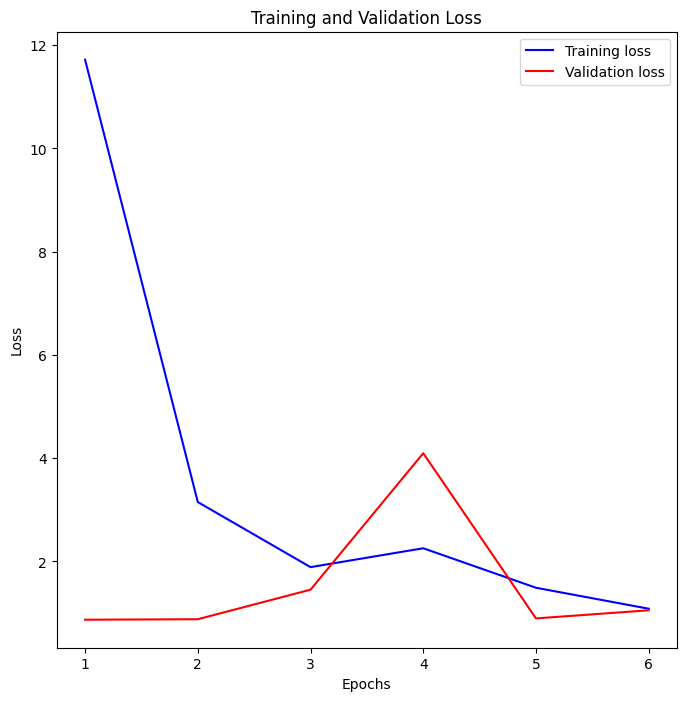

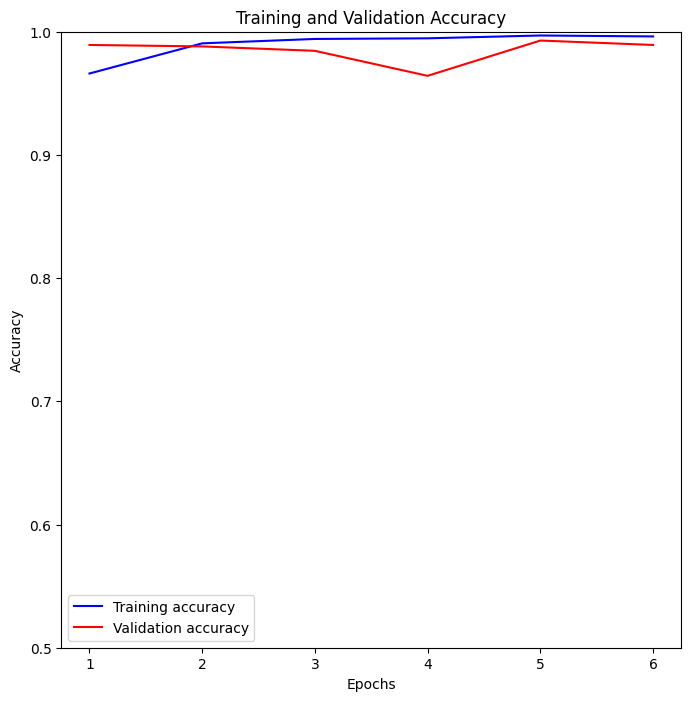

In [37]:
import matplotlib.pyplot as plt

# Extract data from metrics
epochs = [m[0] for m in metrics]
train_loss = [m[2] for m in metrics]
val_loss = [m[4] for m in metrics]
train_accuracy = [m[1] for m in metrics]
val_accuracy = [m[3] for m in metrics]

# Plot training and validation loss
plt.figure(figsize=(8, 8))
plt.plot(epochs, train_loss, color='b', label="Training loss")
plt.plot(epochs, val_loss, color='r', label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.plot(epochs, train_accuracy, color='b', label="Training accuracy")
plt.plot(epochs, val_accuracy, color='r', label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.ylim(0.5, 1)  # Adjust this if accuracy range differs
plt.show()

#### Testing on model till Last Epoch

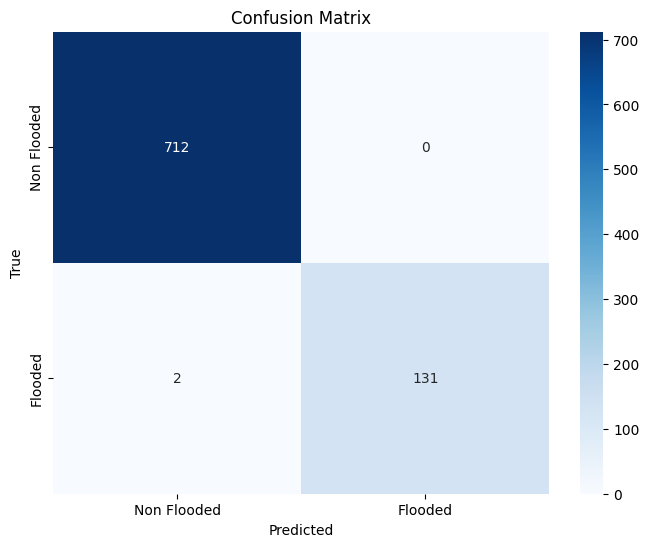

Classification Report:
              precision    recall  f1-score   support

 Non Flooded       1.00      1.00      1.00       712
     Flooded       1.00      0.98      0.99       133

    accuracy                           1.00       845
   macro avg       1.00      0.99      1.00       845
weighted avg       1.00      1.00      1.00       845



In [38]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to collect true labels and predictions
all_labels = []
all_predictions = []

# No gradient computation during testing
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits
        predictions = torch.sigmoid(outputs) if outputs.shape[1] == 1 else torch.softmax(outputs, dim=1)
        
        # Binary classification: threshold at 0.5
        if outputs.shape[1] == 1:  # Single output for binary classification
            predicted_labels = (predictions > 0.5).long()
        else:  # Multi-class classification
            _, predicted_labels = torch.max(predictions, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_labels.cpu().numpy())

# Convert predictions and labels to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['Non Flooded', 'Flooded']))